In [38]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from qiskit.circuit.random import random_circuit


In [39]:
"""Encoder / Decoder"""
import pickle
from typing import Any

from qiskit.providers import Backend
from qiskit_ibm_runtime.utils import RuntimeEncoder, RuntimeDecoder


# pylint: disable=no-else-return, import-outside-toplevel, cyclic-import
class TrialEncoder(RuntimeEncoder):
    """Json encoder for trial."""

    def default(self, obj: Any) -> Any:
        "custom encoder"
        from purplecaffeine.core import BaseStorage

        if isinstance(obj, Backend):
            return {
                "__type__": "Backend",
                "__value__": pickle.dumps(obj),
            }
        elif isinstance(obj, BaseStorage):
            return {"__type__": "PurpleCaffeineStorage"}
        return super().default(obj)


class TrialDecoder(RuntimeDecoder):
    """Json decoder for trial."""

    def object_hook(self, obj: Any) -> Any:
        "custom decoder"
        if "__type__" in obj:
            obj_type = obj["__type__"]

            if obj_type == "Backend":
                return pickle.loads(obj["__value__"])
            elif obj_type == "PurpleCaffeineStorage":
                # we should not recover trial backend
                return None
            return super().object_hook(obj)
        return obj

In [40]:
from typing import List, Optional

import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, clear_output
from ipywidgets import Layout, GridspecLayout, AppLayout

class Widget:
    def __init__(self, storage: Optional[BaseStorage] = None):
        self.storage = storage or LocalStorage("./trials")
        self.limit = 10
        self.offset = 0
        self.trials: List[Trial] = self.storage.list(limit=self.limit, offset=self.offset)
        self.selected_trial: Optional[Trial] = self.trials[0] if len(self.trials) > 0 else None
        self.search_value = ''

        self.list_view = widgets.Output()
        with self.list_view:
            display(self.render_trails_list())

        self.detail_view = widgets.Output()
        with self.detail_view:
            display(self.render_trial())

        self.pagination_view = widgets.Output()
        with self.pagination_view:
            display(self.render_pagination())

        self.load_bootstrap = widgets.Output()
        with self.load_bootstrap:
            display(self.render_bootstrap())
        

    def render_bootstrap(self):
        return widgets.HTML('<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.3/dist/css/bootstrap.min.css" integrity="sha384-rbsA2VBKQhggwzxH7pPCaAqO46MgnOM80zW1RWuH61DGLwZJEdK2Kadq2F9CUG65" crossorigin="anonymous">')

    def load_detail(self, trial_button):
        trial_id = trial_button.tooltip
        trial = self.storage.get(trial_id)
        if isinstance(trial, Trial):
            self.selected_trial = trial
            with self.detail_view:
                clear_output()
                display(self.render_trial())
            with self.load_bootstrap:
                display(self.render_bootstrap())
        else:
            raise Exception("Something went wrong during trial loading.")

    def render_trails_list(self):
        buttons = []
        for trial in self.trials:
            button = widgets.Button(
                description=f"{trial.name} | {trial.uuid}"[:30],
                disabled=False,
                button_style='',
                tooltip=trial.uuid,
                icon=''
            )
            button.layout = Layout(width="95%")
            button.on_click(self.load_detail)
            button.remove_class('lm-Widget')
            button.remove_class('jupyter-widgets')
            button.remove_class('jupyter-button')
            button.remove_class('widget-button')
            button.add_class('btn')
            button.add_class('btn-outline-primary')
            buttons.append(button)

        return widgets.VBox(buttons)

    def paginate(self, page_button):
        if page_button.tooltip == "prev":
            self.trials = self.storage.list(limit=self.limit, offset=self.offset - self.limit, query=self.search_value)
            self.offset = self.offset - self.limit
        elif page_button.tooltip == "next":
            self.trials = self.storage.list(limit=self.limit, offset=self.offset + self.limit, query=self.search_value)
            self.offset = self.offset + self.limit
        with self.list_view:
            clear_output()
            display(self.render_trails_list())
        with self.pagination_view:
            clear_output()
            display(self.render_pagination())
        with self.load_bootstrap:
            display(self.render_bootstrap())

    def render_pagination(self):
        prev_page = widgets.Button(
            description='Prev',
            disabled=self.offset < 1,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            tooltip='prev',
            icon='arrow-circle-left'  # (FontAwesome names without the `fa-` prefix)
        )
        prev_page.on_click(self.paginate)
        prev_page.layout = Layout(width="47%")
        prev_page.add_class('btn')
        prev_page.add_class('btn-secondary')
        next_page = widgets.Button(
            description='Next',
            disabled=len(self.trials) < self.limit,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            tooltip='next',
            icon='arrow-circle-right'  # (FontAwesome names without the `fa-` prefix)
        )
        next_page.add_class('btn')
        next_page.add_class('btn-secondary')
        next_page.on_click(self.paginate)
        next_page.layout = Layout(width="47%")

        return widgets.HBox([prev_page, next_page])
    
    def display_empty(self):
        empty_message = widgets.HTML(
            f"<h1 style='text-align: center;'> <br><br><br>Add a new trial to see the info of that trial </h1>")
        empty_message.layout = Layout(height = '300px')
        return empty_message

    def search(self):
        search = widgets.Text(
            value='',
            placeholder='Name or description',
            description='',
            disabled=False
        )
        search_button = widgets.Button(
            description='Search',
            disabled=False,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            tooltip='search',
            icon=''  # (FontAwesome names without the `fa-` prefix)
        )
        def search_function(search_button):
            self.limit = 10
            self.offset = 0
            if(search.value == ''):
                self.trials = self.storage.list(limit=self.limit, offset=self.offset, query=self.search_value)
            else:
                self.trials = self.storage.list(query=search.value)
            with self.list_view:
                clear_output()
                display(self.render_trails_list())
            with self.detail_view:
                clear_output()
                if(len(self.trials) > 0):
                    self.selected_trial = self.trials[0]
                    display(self.render_trial())
            with self.pagination_view:
                clear_output()
                display(self.render_pagination())
            with self.load_bootstrap:
                display(self.render_bootstrap())
        search.layout = Layout(width="99%")
        search_button.on_click(search_function)
        search_button.add_class('btn');
        search_button.add_class('btn-secondary');
        
        return AppLayout(header=None,
          left_sidebar=search_button,
          center=None,
          right_sidebar=search,
          footer=None, pane_widths=[1, 0, 5],)
        

    def render_trial(self):

        if(self.selected_trial is None):
            return self.display_empty()

        parameter_rows = ''.join([
            f"<tr><td>{str(name)}</td><td><button class='btn btn-primary rounded-pill' disabled>{str(value)}</button></td></tr>"
            for name, value in self.selected_trial.parameters
        ])

        tags = ''.join([
            f"<button class='btn btn-primary rounded-pill btn-sm' style='margin-bottom:20px; margin-right: 10px' disabled>{str(tag)}</button>"
            for tag in self.selected_trial.tags
        ])

        info = widgets.HTML(
            f"<h3>{self.selected_trial.name} | {self.selected_trial.uuid} </h3>"
            f"<p>Description: {self.selected_trial.description }</p>" 
            f"<div>{tags}</div>"
            "<table border=2 class='table'><tr><th>Parameter</th><th>Value</th></tr>"
            '<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.3/dist/css/bootstrap.min.css" integrity="sha384-rbsA2VBKQhggwzxH7pPCaAqO46MgnOM80zW1RWuH61DGLwZJEdK2Kadq2F9CUG65" crossorigin="anonymous">'
            f"{parameter_rows}</table>")
        info.layout = Layout(overflow = 'scroll', max_height = '300px')
        metrics = widgets.Output()
        with metrics:
            df = pd.DataFrame(self.selected_trial.metrics, columns=["name", "value"])
            df2 = df.groupby("name").agg(list)
            for metric_name, values in df2.to_dict()["value"].items():
                if len(values) == 1:
                    pass
                else:
                    
                    plt.plot(values)
                    plt.xlabel("entry")
                    plt.ylabel("value")
                    plt.title(f"Metric: {metric_name}")
                    plt.show()
        metrics.layout = Layout(overflow = 'scroll', max_height = '300px')
        circuits = widgets.Output()
        with circuits:
            for name, circuit in self.selected_trial.circuits:
                print(name)
                print(circuit)
        circuits.layout = Layout(overflow = 'scroll', max_height = '300px')

        tab = widgets.Tab(children=[
            info,
            metrics,
            circuits
        ])
        tab.titles = ["Info", "Metrics", "Circuits"]

        return tab

    def show(self):
        grid = GridspecLayout(2, 1, height='500px')
        grid[0, 0] = self.list_view
        grid[1, 0] = self.pagination_view

        return AppLayout(header=self.search(),
                         left_sidebar=grid,
                         center=self.detail_view,
                         right_sidebar=None,
                         footer=None, pane_widths=[0.5, 1, 1],
                         pane_heights=[0.5, 5, 1])
local_storage = LocalStorage("./trials")

In [41]:
local_storage = LocalStorage("./")

In [127]:
from typing import List, Optional

import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display, clear_output
from ipywidgets import Layout, GridspecLayout, AppLayout

class Widget:
    def __init__(self, storage: Optional[BaseStorage] = None):
        self.storage = storage or LocalStorage("./trials")
        self.limit = 10
        self.offset = 0
        self.trials: List[Trial] = self.storage.list(limit=self.limit, offset=self.offset)
        self.selected_trial: Optional[Trial] = self.trials[0] if len(self.trials) > 0 else None
        self.search_value = ''

        self.list_view = widgets.Output()
        with self.list_view:
            display(self.render_trails_list())

        self.detail_view = widgets.Output()
        with self.detail_view:
            display(self.render_trial())

        self.pagination_view = widgets.Output()
        with self.pagination_view:
            display(self.render_pagination())

        self.load_bootstrap = widgets.Output()
        with self.load_bootstrap:
            display(self.render_bootstrap())
        

    def render_bootstrap(self):
        return widgets.HTML('<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.3/dist/css/bootstrap.min.css" integrity="sha384-rbsA2VBKQhggwzxH7pPCaAqO46MgnOM80zW1RWuH61DGLwZJEdK2Kadq2F9CUG65" crossorigin="anonymous">')

    def load_detail(self, trial_button):
        trial_id = trial_button.tooltip
        trial = self.storage.get(trial_id)
        if isinstance(trial, Trial):
            self.selected_trial = trial
            with self.detail_view:
                clear_output()
                display(self.render_trial())
            with self.load_bootstrap:
                display(self.render_bootstrap())
        else:
            raise Exception("Something went wrong during trial loading.")

    def render_trails_list(self):
        buttons = []
        for trial in self.trials:
            button = widgets.Button(
                description=f"{trial.name} | {trial.uuid}"[:30],
                disabled=False,
                button_style='',
                tooltip=trial.uuid,
                icon=''
            )
            button.layout = Layout(width="95%")
            button.on_click(self.load_detail)
            button.remove_class('lm-Widget')
            button.remove_class('jupyter-widgets')
            button.remove_class('jupyter-button')
            button.remove_class('widget-button')
            button.add_class('btn')
            button.add_class('btn-outline-primary')
            buttons.append(button)

        return widgets.VBox(buttons)

    def paginate(self, page_button):
        if page_button.tooltip == "prev":
            self.trials = self.storage.list(limit=self.limit, offset=self.offset - self.limit, query=self.search_value)
            self.offset = self.offset - self.limit
        elif page_button.tooltip == "next":
            self.trials = self.storage.list(limit=self.limit, offset=self.offset + self.limit, query=self.search_value)
            self.offset = self.offset + self.limit
        with self.list_view:
            clear_output()
            display(self.render_trails_list())
        with self.pagination_view:
            clear_output()
            display(self.render_pagination())
        with self.load_bootstrap:
            display(self.render_bootstrap())

    def render_pagination(self):
        prev_page = widgets.Button(
            description='Prev',
            disabled=self.offset < 1,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            tooltip='prev',
            icon='arrow-circle-left'  # (FontAwesome names without the `fa-` prefix)
        )
        prev_page.on_click(self.paginate)
        prev_page.layout = Layout(width="47%")
        prev_page.add_class('btn')
        prev_page.add_class('btn-secondary')
        next_page = widgets.Button(
            description='Next',
            disabled=len(self.trials) < self.limit,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            tooltip='next',
            icon='arrow-circle-right'  # (FontAwesome names without the `fa-` prefix)
        )
        next_page.add_class('btn')
        next_page.add_class('btn-secondary')
        next_page.on_click(self.paginate)
        next_page.layout = Layout(width="47%")

        return widgets.HBox([prev_page, next_page])
    
    def display_empty(self):
        empty_message = widgets.HTML(
            f"<h1 style='text-align: center;'> <br><br><br>Add a new trial to see the info of that trial </h1>")
        empty_message.layout = Layout(height = '300px')
        return empty_message

    def search(self):
        search = widgets.Text(
            value='',
            placeholder='Name or description',
            description='',
            disabled=False
        )
        search_button = widgets.Button(
            description='Search',
            disabled=False,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            tooltip='search',
            icon=''  # (FontAwesome names without the `fa-` prefix)
        )
        def search_function(search_button):
            self.search_value = search.value
            self.limit = 10
            self.offset = 0
            if(search.value == ''):
                self.trials = self.storage.list(limit=self.limit, offset=self.offset, query=self.search_value)
            else:
                self.trials = self.storage.list(query=search.value)
            with self.list_view:
                clear_output()
                display(self.render_trails_list())
            with self.detail_view:
                clear_output()
                if(len(self.trials) > 0):
                    self.selected_trial = self.trials[0]
                    display(self.render_trial())
            with self.pagination_view:
                clear_output()
                display(self.render_pagination())
            with self.load_bootstrap:
                display(self.render_bootstrap())
        search.layout = Layout(width="99%")
        search_button.on_click(search_function)
        search_button.add_class('btn');
        search_button.add_class('btn-secondary');
        
        return AppLayout(header=None,
          left_sidebar=search_button,
          center=None,
          right_sidebar=search,
          footer=None, pane_widths=[1, 0, 5],)
        

    def render_trial(self):

        if(self.selected_trial is None):
            return self.display_empty()

        parameter_rows = ''.join([
            f"<tr><td>{str(name)}</td><td><button class='btn btn-primary rounded-pill' disabled>{str(value)}</button></td></tr>"
            for name, value in self.selected_trial.parameters
        ])

        tags = ''.join([
            f"<button class='btn btn-primary rounded-pill btn-sm' style='margin-bottom:20px; margin-right: 10px' disabled>{str(tag)}</button>"
            for tag in self.selected_trial.tags
        ])

        info = widgets.HTML(
            f"<h3>{self.selected_trial.name} | {self.selected_trial.uuid} </h3>"
            f"<p>Description: {self.selected_trial.description }</p>" 
            f"<div>{tags}</div>"
            "<table border=2 class='table'><tr><th>Parameter</th><th>Value</th></tr>"
            '<link rel="stylesheet" href="https://cdn.jsdelivr.net/npm/bootstrap@5.2.3/dist/css/bootstrap.min.css" integrity="sha384-rbsA2VBKQhggwzxH7pPCaAqO46MgnOM80zW1RWuH61DGLwZJEdK2Kadq2F9CUG65" crossorigin="anonymous">'
            f"{parameter_rows}</table>")
        info.layout = Layout(overflow = 'scroll', max_height = '300px')
        metrics = widgets.Output()
        with metrics:
            df = pd.DataFrame(self.selected_trial.metrics, columns=["name", "value"])
            df2 = df.groupby("name").agg(list)
            for metric_name, values in df2.to_dict()["value"].items():
                if len(values) == 1:
                    pass
                else:
                    
                    plt.plot(values)
                    plt.xlabel("entry")
                    plt.ylabel("value")
                    plt.title(f"Metric: {metric_name}")
                    plt.show()
        metrics.layout = Layout(overflow = 'scroll', max_height = '300px')
        circuits = widgets.Output()
        with circuits:
            for name, circuit in self.selected_trial.circuits:
                print(name)
                print(circuit)
        circuits.layout = Layout(overflow = 'scroll', max_height = '300px')

        tab = widgets.Tab(children=[
            info,
            metrics,
            circuits
        ])
        tab.titles = ["Info", "Metrics", "Circuits"]

        return tab

    def show(self):
        grid = GridspecLayout(2, 1, height='500px')
        grid[0, 0] = self.list_view
        grid[1, 0] = self.pagination_view

        return AppLayout(header=self.search(),
                         left_sidebar=grid,
                         center=self.detail_view,
                         right_sidebar=None,
                         footer=None, pane_widths=[0.5, 1, 1],
                         pane_heights=[0.5, 5, 1])
local_storage = LocalStorage("./trials")

In [129]:
Widget(local_storage).show()

AppLayout(children=(AppLayout(children=(Button(description='Search', layout=Layout(grid_area='left-sidebar'), …

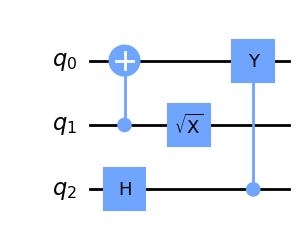

In [78]:
random_circuit(3, 2).draw('mpl')

In [10]:
list(filter(lambda trial: '2' in trial, ['trial #' + str(i) for i in range(0,20)]))

['trial #2', 'trial #12']

In [112]:
local_storage.list(query='1')

[<Trial [Example trial 3] f6566659-45dd-47bf-bb26-a301b98bc9c3>,
 <Trial [Example trial 17] e15bffbf-4bde-4a1e-8f5e-ee2198870687>,
 <Trial [Example trial 18] 567fe539-056b-47a1-a9d2-388263df6b72>,
 <Trial [Example trial 11] 8e99776d-a386-44d4-b6d7-9fd8b795ce13>,
 <Trial [Example trial 13] aad22892-ed21-4a50-aeb0-390ec522dcb0>,
 <Trial [Example trial 8] e880bc3f-7e42-4ea4-a6c0-606aadd80450>,
 <Trial [Example trial 16] bbdba909-27e1-4ff7-8775-5c38a2d3379c>,
 <Trial [Example trial 12] 4624540e-28ec-42d7-b5f5-e2d7df1b04b3>,
 <Trial [Example trial 7] f1a24705-39a6-403c-b841-cacf20082917>,
 <Trial [Example trial 6] 37cac684-c29a-4c67-9664-7f688d981ddd>]

In [65]:
local_storage = LocalStorage("./")

In [110]:
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info.random import random_pauli
from qiskit.primitives import Estimator

from purplecaffeine.core import Trial, LocalStorage

n_qubits = 4
depth = 3
shots = 2000

circuit = random_circuit(n_qubits, depth)
obs = random_pauli(n_qubits)


for i in range(0, 20):
    with Trial("Example trial " + str(i), storage=local_storage) as trial:
        # track some parameters
        trial.add_parameter("estimator", "qiskit.primitives.Estimator")
        trial.add_parameter("depth", depth)
        trial.add_parameter("n_qubits", n_qubits)
        trial.add_parameter("shots", shots)
        
        # track objects of interest
        trial.add_circuit("circuit", circuit)
        trial.add_operator("obs", obs)
    
        # run
        exp_value = Estimator().run(circuit, obs, shots=shots).result().values.item()
        
        # track results of run
        trial.add_metric("exp_value", exp_value)